In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy

#compare
p0 = 101325
T0 = 300 #paper
phi = 0.7
alpha = 0.6 #paper>0.6~0.8
width = 0.02 #2cm
loglevel = 0

xh2 = alpha / (1 - alpha) * 1
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

gas = ct.Solution('gri30.yaml')
gas.TP = T0, p0
gas.set_equivalence_ratio(phi, fuel, oxidizer)

In [2]:
flame = ct.FreeFlame(gas, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0]
print(f'Flame speed: {flame_speed:.5f} m/s')

Flame speed: 0.34056 m/s


In [3]:
# get adiabatic temperature from the FreeFlame object
def get_adiabatic_temperature_from_flame(flame): # lamninar unstretched flame
    Tad = flame.T[-1]  # final status of the flame
    return Tad

Tad = get_adiabatic_temperature_from_flame(flame)   ## (Viken) adiabatic temperature should be from the laminar unstretched configuration
print(f'Adiabatic temperature (Tad) from FreeFlame: {Tad:.2f} K')
Xflame = flame.X[:,-1] ## (viken)
#print(Xflame)

### (viken) use laminar flame to compute the thermal diffusivity, only needed once per operating conditions
cp      = flame.cp_mass[0]
density = flame.density_mass[0]    
lambda_     = flame.thermal_conductivity[0]
thermal_diffusivity = lambda_ / (density * cp)

Adiabatic temperature (Tad) from FreeFlame: 1820.61 K


In [4]:
def calculate_heat_loss_coefficient(Tp, Tad, Tr):
    beta = (Tp - Tr) / (Tad - Tr)
    return beta

In [5]:
#check minus sign (integral_numerator, mass_fraction_diff)
#modify the func to reflect Ka, beta?
def calculate_consumption_speed(flame_cf, gas, fuel_species):
    rho_u = flame_cf.density[0]
    total_fuel_mass_fraction = sum(flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)

    integral_numerator = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        nk = flame_cf.Y[i_fuel, 0] / total_fuel_mass_fraction
        integral = scipy.integrate.simpson(gas.molecular_weights[i_fuel] * flame_cf.net_production_rates[i_fuel], x=flame_cf.grid)
        integral_numerator += nk * integral

    mass_fraction_diff = sum(flame_cf.Y[gas.species_index(fuel), -1] - flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)
    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    #print("Integral Numerator:", integral_numerator) #check if it has a right sign
    #print("Mass Fraction Difference:", mass_fraction_diff)
    return S_cF

In [104]:
#mdot_values = [0.025, 0.1, 1, 60]
mdot_values = [0.025, 0.05, 0.075, 0.1, 0.3, 5, 20, 40, 60]
Ka_values = []
ScF_values = []

# Generate 10 mdot values in log scale
#mdot_min, mdot_max = 0.025, 60
#mdot_values = np.logspace(np.log10(mdot_min), np.log10(mdot_max), num=10)

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tad  ## no heat loss
    flame_cf.products.X = Xflame     ## (viken)
    flame_cf.set_initial_guess(equilibrate=False)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = 300  ## (viken) you are reading the product temperature, you should write it
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])  # Ensure positive value for Ka calculation
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka_values.append(Ka)
    #print(f"Strain rate (Ka): {Ka:.5e}")
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF_values.append(ScF)
    print(ScF)

0.03164756600486678
0.05621436486940528
0.0784180929489242
0.09969092685109243
0.2296153968491524
0.29204774063928796
0.2682039289370276
0.24199824529416175
0.21410532786600245


In [92]:
Tp = [300, 453, 605, 757, 909, 1061, 1213, 1365, 1517, 1670, 1820.61]
for temp in Tp:
    beta = calculate_heat_loss_coefficient(temp, Tad, T0) #beta
    print(beta)

0.0
0.10061756340270997
0.2005774956720689
0.30053742794142785
0.40049736021078675
0.5004572924801457
0.6004172247495047
0.7003771570188635
0.8003370892882224
0.9009546526909324
1.0000004776849334


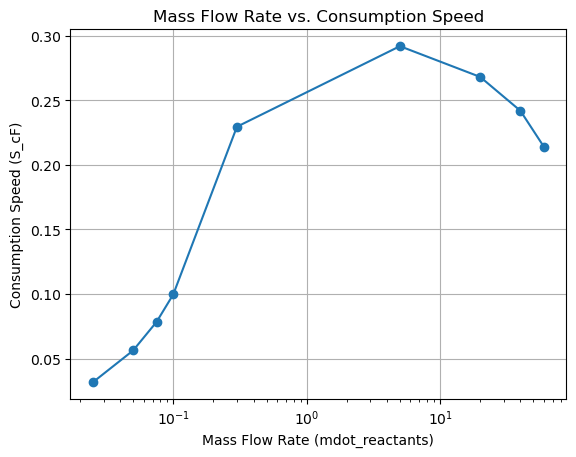

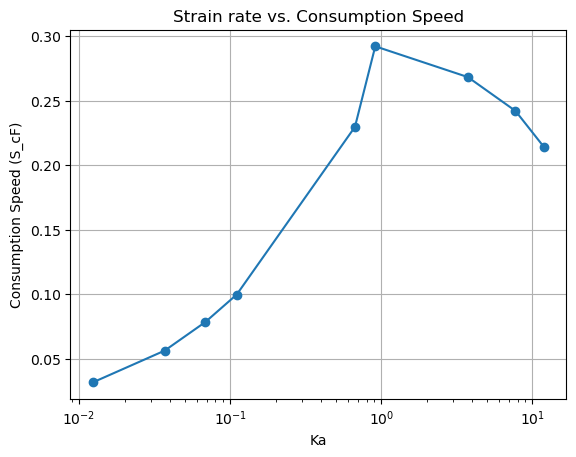

In [116]:
plt.plot(mdot_values, ScF_values, marker='o')
plt.xscale('log')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('Consumption Speed (S_cF)')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.show()

plt.plot(Ka_values, ScF_values, marker='o')
plt.xscale('log')
plt.xlabel('Ka')
plt.ylabel('Consumption Speed (S_cF)')
plt.title('Strain rate vs. Consumption Speed')
plt.grid(True)
plt.show()

In [98]:
Tp_values = [300, 453, 605, 757, 909, 1061, 1213, 1365, 1517, 1670, 1820.61]
mdot_values = [0.025, 0.05, 0.075, 0.1, 20, 40, 60]
Ka_values = []
ScF_values = []

# Loop through Tp values
for Tp in Tp_values:
    for mdot in mdot_values:
        # Initialize gas object
        gas = ct.Solution('gri30.yaml')
        gas.TP = T0, p0
        gas.set_equivalence_ratio(phi, fuel, oxidizer)
        
        # Initialize and configure the flame object
        flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
        flame_cf.transport_model = 'multicomponent'
        flame_cf.energy_enabled = True
        flame.soret_enabled = True
        flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
        flame_cf.reactants.mdot = mdot
        flame_cf.products.mdot = mdot
        flame_cf.products.T = Tp  # Use Tp from loop
        flame_cf.set_initial_guess(equilibrate=False)
        
        flame_cf.solve(loglevel, auto=True)

        # Calculate maximum gradient |du/dx|
        grad_u = np.gradient(flame_cf.velocity, flame_cf.grid)
        max_grad_idx = np.argmax(np.abs(grad_u))
        max_grad_value = np.abs(grad_u[max_grad_idx])

        # Calculate strain rate (Ka)
        Ka = (thermal_diffusivity / flame_speed) * max_grad_value
        Ka_values.append(Ka)
        
        # Calculate consumption speed (ScF)
        ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
        ScF_values.append(ScF)
        print(ScF)

2.623163249268289e-11
-1.561168970624467e-11
2.6046918762463158e-12
-2.4226347040152127e-12
-3.10711743601949e-13
-3.79581728380706e-14
-9.891230945875202e-14
2.285113355050811e-11
1.3802655284993544e-11
-6.501292608966222e-11
2.6479435490002597e-11
3.151945164688445e-14
-6.217790242031242e-13
9.731631880077442e-13
-7.712157614177986e-11
1.1736201850469368e-11
3.0256730881486855e-11
-1.083497785887869e-13
-6.479448959380499e-15
2.4052072917272904e-13
1.2014796690665568e-14
-1.778564046017756e-11
-8.616551598084342e-11
-3.160901933374898e-11
-1.6074902435053132e-10
-2.238237175214802e-13
1.0146411745432475e-13
-6.220665792401219e-14
-4.219554773325501e-11
-1.8057580060638524e-10
-1.000001600765944e-11
1.3659754567035295e-11
5.049526890272593e-13
-3.655000563161564e-14
2.7632544405904065e-13
-0.00024428640049164844
-0.0010795336993818204
-0.001740617745671644
-0.002514347382323403
-1.4317989572912313e-11
-7.040205461987888e-12
-5.780574686060614e-12
-0.0005957418521363863
-0.001107872762

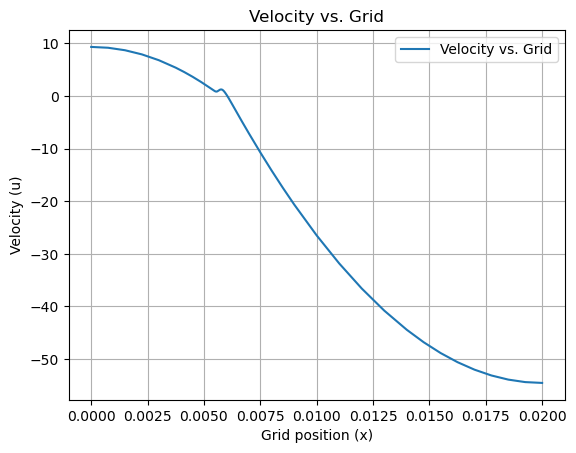

In [17]:
# plot grid-velocity graph
plt.plot(flame_cf.grid, flame_cf.velocity, label='Velocity vs. Grid')
plt.xlabel('Grid position (x)')
plt.ylabel('Velocity (u)')
plt.title('Velocity vs. Grid')
plt.legend()
plt.grid(True)
plt.show()